# Measuring Performance

Here's some examples of how to find the optimal worker count and chunk size for different Dask operations. See the scripts in [the github repository](https://github.com/coecms-training/parallel/tree/main/case-studies/read_speed) for samples of how these were measured.

:::{note}
The first time a file is read can be quite slow if it's not in cache. When running benchmarks make sure to load the file fully once (e.g. with `data.mean().load()`) before doing any timing.
:::

In [1]:
import pandas
import numpy
import dask
import matplotlib.pyplot as plt

## ERA5 single level one year mean

Lets look at performance for reading in a year of ERA5 single level data. This data comes from compressed netcdf files, so the time spent decompressing will affect our measurements.

I've run for various chunk sizes and Dask cluster sizes
```python
path = "/g/data/rt52/era5/single-levels/reanalysis/2t/2001/2t_era5_oper_sfc_*.nc"
with xarray.open_mfdataset(
    path, combine="nested", concat_dim="time", chunks=chunks
) as ds:
    var = ds[variable]

    start = time.perf_counter()
    mean = var.mean().load()
    duration = time.perf_counter() - start
```
and saved the results in a netcdf file

In [2]:
df = pandas.read_csv('read_speed/era5_t2_load.csv')
df

,duration,data_size,chunk_size,time,latitude,longitude,workers,threads
0,38.058817,36379929600,194987520,NaN,182,360,4,1
1,38.475415,36379929600,97493760,NaN,182,180,4,1
2,38.962101,36379929600,48746880,NaN,91,180,4,1
3,39.011292,36379929600,97493760,NaN,91,360,4,1
4,50.406360,36379929600,6093360,93.0,91,180,4,1
...,...,...,...,...,...,...,...,...
112,17.296662,36379929600,6093360,93.0,91,180,16,1
113,18.460571,36379929600,97493760,NaN,182,180,16,1
114,18.579301,36379929600,97493760,NaN,91,360,16,1
115,20.263248,36379929600,194987520,NaN,182,360,16,1


To start off with, let's look at the mean walltime for a given cluster and chunk size. I'll focus on a single thread as well.

In [3]:
mean = df.groupby(['workers','chunk_size','threads']).mean().reset_index()
one_thread = mean[mean.threads == 1]

and to narrow the results down further I'll select a single chunk layout of `{'time': None, 'latitude': 91, 'longitude': 180}`. This is the file chunk size in the horizontal dimensions, about 49 MB per chunk.

In [4]:
df_91_180 = one_thread[(one_thread.latitude==91) & (one_thread.longitude==180) & numpy.isnan(one_thread.time)]
df_91_180 = df_91_180.set_index('workers', drop=False)
df_91_180

,workers,chunk_size,threads,duration,data_size,time,latitude,longitude
workers,,,,,,,,
1,1,48746880,1,192.943019,3.637993e+10,NaN,91.0,180.0
2,2,48746880,1,86.172158,3.637993e+10,NaN,91.0,180.0
4,4,48746880,1,39.269419,3.637993e+10,NaN,91.0,180.0
8,8,48746880,1,21.874852,3.637993e+10,NaN,91.0,180.0
16,16,48746880,1,13.159739,3.637993e+10,NaN,91.0,180.0
32,32,48746880,1,7.959964,3.637993e+10,NaN,91.0,180.0
48,48,48746880,1,6.344361,3.637993e+10,NaN,91.0,180.0


Plotting the walltime taken for different worker sizes looks good, ideally this should be proportional to $ 1 / \textrm{workers}$.

:::{note}
The maximum number of CPUs on a single Gadi node is 48, and the default Dask cluster can't go beyond that.
:::

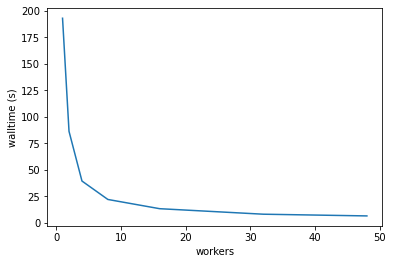

In [5]:
wall = (df_91_180['duration'])
wall.plot()
plt.ylabel('walltime (s)');

Gadi's run costs are proportional to $\textrm{walltime}\times\textrm{workers}$. The cost minimum is at about 4 workers.

:::{note}
Remember this is the cost for _just_ loading the data and calculating the global mean. Further processing can affect the cost scaling as well
:::

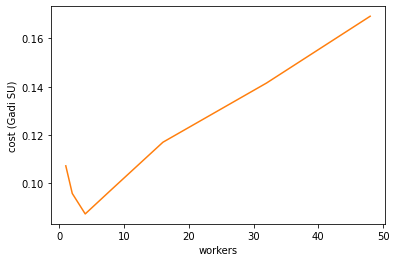

In [6]:
cost = (df_91_180['duration'] * df_91_180['workers']/60/60*2)
cost.plot(color='tab:orange')
plt.ylabel('cost (Gadi SU)');

To find a good balance of walltime and cost we want to minimise $\textrm{walltime}\times\textrm{cost}$. The best worker count by this metric for this single operation is 32 workers.

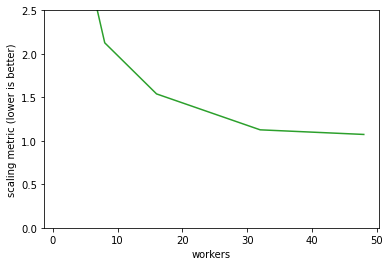

In [7]:
(wall * cost).plot(color='tab:green')
plt.ylim([0,2.5])
plt.ylabel('scaling metric (lower is better)');

We've worked out the best worker count to use, how about the chunk size? The best size here is in the 50 to 100 MB range. Generally the chunk size should be an integer multiple of the file chunk size to make things easy for the NetCDF library, but this doesn't have a huge effect.

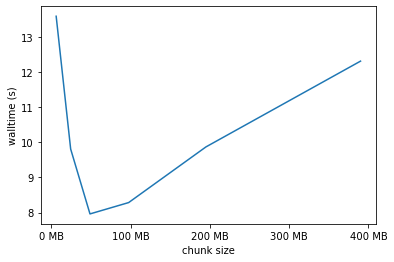

In [8]:
one_thread[one_thread.workers == 32].plot('chunk_size','duration', legend=False)

xlabels = ['0 MB', '100 MB', '200 MB', '300 MB', '400 MB']
plt.xticks([dask.utils.parse_bytes(x) for x in xlabels], labels=xlabels)

plt.xlabel('chunk size');
plt.ylabel('walltime (s)');

In [71]:
def result_scaling(df):
    wall = df['duration']
    cost = df['duration'] * df['workers'] / 60 / 60 * 2
    scaling = wall * cost
    return wall, cost, scaling

def plot_results(csv, target_workers=32):
    df = pandas.read_csv(csv)
    
    mean = df.groupby(['workers','chunk_size','threads']).mean().reset_index()
    one_thread = mean[mean.threads == 1]
    df_91_180 = one_thread[(one_thread.latitude==91) & (one_thread.longitude==180)]
    df_91_180 = df_91_180.set_index('workers', drop=False)
    
    wall, cost, scaling = result_scaling(df_91_180)
    
    ax = plt.subplot(2,3,1)
    wall.plot(ax=ax, color='tab:blue')
    plt.ylabel('walltime (s)');
        
    ax = plt.subplot(2,3,2)
    cost.plot(color='tab:orange')
    plt.ylabel('cost (Gadi SU)');
    
    ax = plt.subplot(2,3,3)
    scaling.plot(color='tab:green')
    #plt.ylim([0,1200])
    plt.ylabel('scaling metric (lower is better)');
    
    df_chunksize = one_thread[one_thread.workers == target_workers].set_index('chunk_size', drop=False)
    wall, cost, scaling = result_scaling(df_chunksize)
    
    xlabels = ['0 MB', '100 MB', '200 MB', '300 MB']
    
    ax = plt.subplot(2,3,4)
    wall.plot(ax=ax, color='tab:blue')
    plt.xticks([dask.utils.parse_bytes(x) for x in xlabels], labels=xlabels)
    plt.xlabel('chunk size');
    plt.ylabel('walltime (s)');
    
    ax = plt.subplot(2,3,5)
    cost.plot(ax=ax, color='tab:orange')
    plt.xticks([dask.utils.parse_bytes(x) for x in xlabels], labels=xlabels)
    plt.xlabel('chunk size');
    plt.ylabel('cost (Gadi SU)');
    
    ax = plt.subplot(2,3,6)
    scaling.plot(ax=ax, color='tab:green')
    plt.xticks([dask.utils.parse_bytes(x) for x in xlabels], labels=xlabels)
    plt.xlabel('chunk size');
    plt.ylabel('scaling metric (lower is better)');

def optimal_size(csv):
    df = pandas.read_csv(csv)
    mean = df.groupby(['workers','chunk_size','threads']).mean().reset_index()
    
    cost = mean['duration']*mean['duration']*mean['workers']
    opt = mean.iloc[cost.sort_values().index[0]]
    print(f'Workers:  {opt.workers:2.0f}')
    print(f'Threads:  {opt.threads:2.0f}')
    print(f"Walltime:  {pandas.Timedelta(opt.duration, 's').round('s')}")
    print(f"Cost:     {(opt.duration/60/60)**2*opt.workers*2:5.2f} SU")
    print(f"Chunks:   {opt[['latitude', 'longitude']].to_dict()}")

## ERA5 10-year climatology

Calculating a daily mean climatology from 10 years of hourly ERA5 data, using climtas functions for resampling and groupby, saving the results to a compressed netcdf file.


```python
path = "/g/data/rt52/era5/single-levels/reanalysis/2t/200*/2t_era5_oper_sfc_*.nc"
var = 't2m'

with xarray.open_mfdataset(
    path, combine="nested", concat_dim="time", chunks=chunks
) as ds:
    var = ds[variable]
    if isel is not None:
        var = var.isel(**isel)

    out = os.path.join(os.environ['TMPDIR'],'sample.nc')

    start = time.perf_counter()
    daily = climtas.blocked_resample(var, time=24).mean()
    climatology = climtas.blocked_groupby(daily, time='dayofyear').mean()
    climtas.io.to_netcdf_throttled(climatology, out)
    duration = time.perf_counter() - start

```

Workers: 48.0


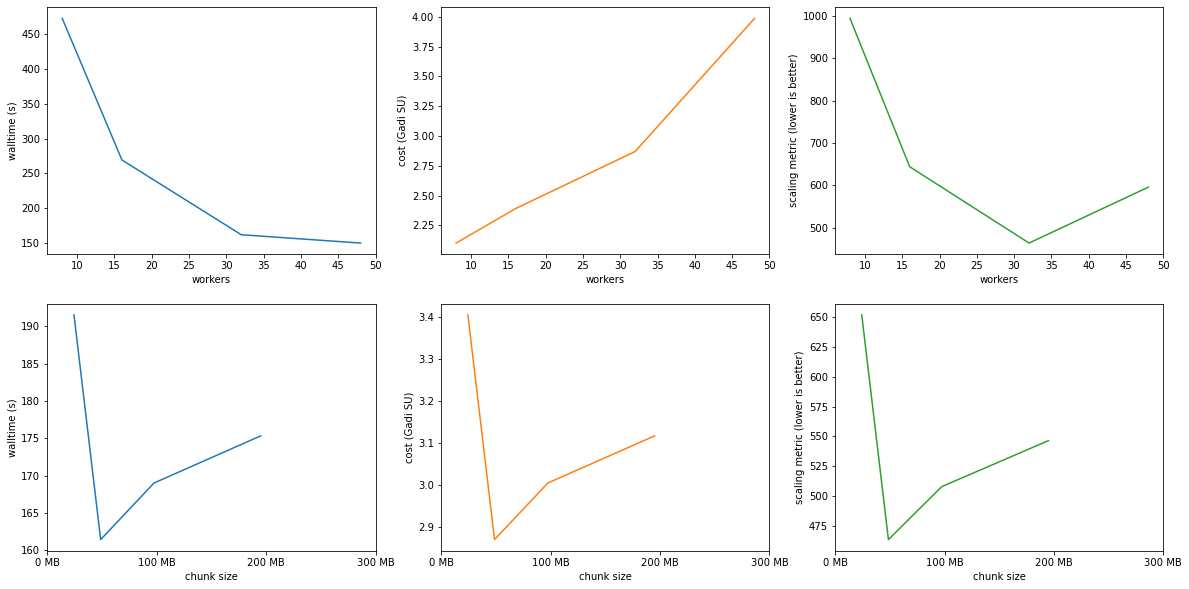

In [25]:
plt.figure(figsize=(20,10))
plot_results('read_speed/era5_t2_climatology.csv', target_workers=32)

### Optimal results:

In [72]:
optimal_size('read_speed/era5_t2_climatology.csv')

Workers:  32
Threads:   1
Walltime:  0 days 00:02:41
Cost:      0.13 SU
Chunks:   {'latitude': 91.0, 'longitude': 180.0}
